#### Libraries

In [1]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import random
from scipy.stats import mode

#### Helper Functions

In [2]:
# Workaround to print images inside the Jupyter Notebook (cv.imshow method seems to be incompatible with Jupyter)
def display_img(image):
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [3]:
# Print images side to side for comparison inside the Jupyter Notebook
def display_img_comp(image_1, image_2, lab_1, lab_2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))   

    # Plot data on the first axis
    ax1.imshow(cv.cvtColor(image_1, cv.COLOR_BGR2RGB))
    ax1.set_title(lab_1)
    ax1.axis('off')

    # Plot data on the second axis
    ax2.imshow(cv.cvtColor(image_2, cv.COLOR_BGR2RGB))
    ax2.set_title(lab_2)
    ax2.axis('off')

    fig.tight_layout()
    plt.show()

In [4]:
# Enhance contrast using Constrast Limited Adaptive Histogram Equalization
def enhance_contrast_img(img, clipLimit=1.0, tileGridSize=(8,8)):
    # Convert the image to 8-bit unsigned single channel (Gray Scale is required for CLAHE)
    img_p = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Apply CLAHE
    clahe = cv.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    img_p = clahe.apply(img_p)

    return img_p
    
# Resize image
def resize_img(img, width, height):
    img_p = cv.resize(img, (width, height))
    return img_p

In [5]:
# The whole pre-processing pipeline for a single image
def preprocess_image(img, resize=True):
    img_p = enhance_contrast_img(img)   
    
    # Resize the image
    if(resize):
        img_p = resize_img(img, 500, 500)
          
    return img_p

### Read the Data

In [23]:
# Parameters
width = 2500
height = 2500

# Input & Output Paths
img_paths_src_dict = {
    'training': r'data\Bone Age Datasets\Bone Age Training Set\boneage-training-dataset\boneage-training-dataset'
    , 'validation_1': r'data\Bone Age Datasets\Bone Age Validation Set\boneage-validation-dataset-1\boneage-validation-dataset-1'
    , 'validation_2': r'data\Bone Age Datasets\Bone Age Validation Set\boneage-validation-dataset-2\boneage-validation-dataset-2'
    , 'test': r'data\Bone Age Datasets\Bone Age Test Set\Test Set Images'
}

img_paths_dest_dict = {
    'training': r'data\pre_processed\training'
    , 'validation_1': r'data\pre_processed\validation\validation_1'
    , 'validation_2': r'data\pre_processed\validation\validation_2'
    , 'test': r'data\pre_processed\test'
}

# Get the relative paths for all images per split of the data
img_rel_paths_dict = {}

for split in img_paths_src_dict:
    rel_paths_split = {}
    dir = img_paths_src_dict[split]
    file_names = [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]
    relative_paths = [os.path.join(dir, f) for f in file_names]

    for path in relative_paths:
        img_id = int((path.split('\\')[-1]).split('.')[0])
        rel_paths_split[img_id] = path

    img_rel_paths_dict[split] = rel_paths_split

In [99]:
# Function that writes the outputs of the processed images to disk
# def pre_process_imgs(img_rel_paths_dict, dataset_name, function):

# For each split (Training, Test, Validation sets)
dataset_name = 'raw_resized_250px'

for split in img_rel_paths_dict.keys():
    # Get the source paths of images in the split, and the path of their destination
    img_paths_analysis = img_rel_paths_dict[split]  
    path_split_dest = img_paths_dest_dict[split]

    # Create a folder with the datasetname inside that path, if it doesn't exist yet
    path_dest = '{0}\{1}'.format(path_split_dest, dataset_name)
    path_exists = os.path.exists(path_dest)
    
    if not path_exists:
        # Create a new directory because it does not exist
        os.makedirs(path_dest)

    # For each image belonging to the split, process the image and write the result to the provided folder
    for img_key in img_paths_analysis.keys():
        path_p = '{0}\{1}.png'.format(path_dest, img_key)
        path_src = img_paths_analysis[img_key]
        img_src = cv.imread(path_src)

        # Function to apply to the image before writing
        img_p = resize_img(img_src, 250, 250)

        cv.imwrite(path_p, img_p)

        # print(path_p)

        # Clean the memory for that image, as it is no longer needed
        del img_src, img_p

### Sampling

In [31]:
# Define where the sampling is done
split_sampling = 'training'

# Take % amount of samples of images from the training set to analyze
random.seed(642)
perc_samples = 0.25
n_samples = int(round(perc_samples*len(img_rel_paths_dict[split_sampling]), 0))
img_paths_analysis = random.sample(list(img_rel_paths_dict[split_sampling].keys()), n_samples)

# Read the images, preprocess and put both the source and the pre-processed image into a dictionary 
images = {}
for img_key in img_paths_analysis:
    img_src = cv.imread(img_rel_paths_dict[split_sampling][img_key])
    img_p = preprocess_image(img_src, resize=False)
    images[img_key] = {'img_src': img_src, 'img_p': img_p}

### Exploratory Data Analysis

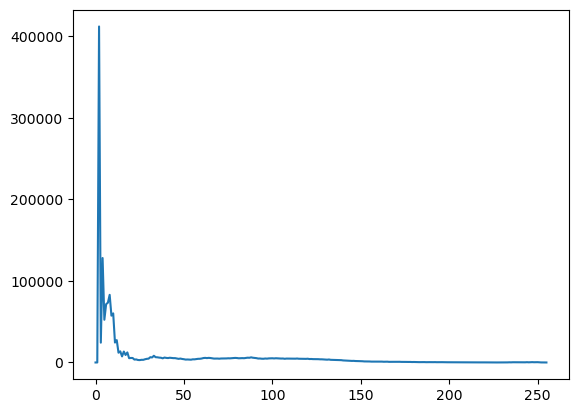

In [41]:
img_list = [images[img_key]['img_p'] for img_key in images ]

# The histogram for all images
hist = cv.calcHist(img_list, [0], None, [256], [0,256])
plt.plot(hist)
plt.show()

### Analysis Per Image (Tests)

In [46]:
img_comp = images[8020]
img = np.copy(img_comp['img_p'])

# First we convert do a binary threshold in the image to make contours more evident
_, img_thr = cv.threshold(img, 185, 255, cv.THRESH_BINARY)

# Gaussian Blur to smooth the image
img_blur = cv.GaussianBlur(img_thr, (137, 137), 15)

# Then we find the contours
contours, hierarchy = cv.findContours(img_blur, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.drawContours(img, contours, -1, (0, 255, 0), 5)
# cv.drawContours(img, contours[hierarchy[0][0][2]], -1, (0,255,0), 5)

array([[[15, 15, 15],
        [14, 14, 14],
        [14, 14, 14],
        ...,
        [ 4,  4,  4],
        [ 2,  2,  2],
        [ 2,  2,  2]],

       [[14, 14, 14],
        [14, 14, 14],
        [15, 15, 15],
        ...,
        [ 4,  4,  4],
        [ 4,  4,  4],
        [ 6,  6,  6]],

       [[14, 14, 14],
        [14, 14, 14],
        [14, 14, 14],
        ...,
        [ 4,  4,  4],
        [ 4,  4,  4],
        [ 4,  4,  4]],

       ...,

       [[18, 18, 18],
        [18, 18, 18],
        [18, 18, 18],
        ...,
        [ 9,  9,  9],
        [ 9,  9,  9],
        [ 9,  9,  9]],

       [[20, 20, 20],
        [18, 18, 18],
        [18, 18, 18],
        ...,
        [ 9,  9,  9],
        [ 9,  9,  9],
        [ 9,  9,  9]],

       [[20, 20, 20],
        [18, 18, 18],
        [18, 18, 18],
        ...,
        [ 9,  9,  9],
        [ 9,  9,  9],
        [ 9,  9,  9]]], dtype=uint8)

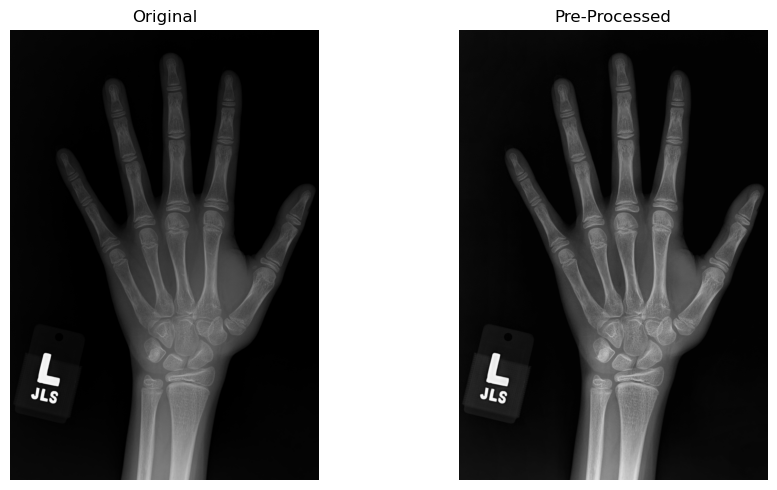

In [47]:
display_img_comp(img_comp['img_src'], img_comp['img_p'], 'Original', 'Pre-Processed')

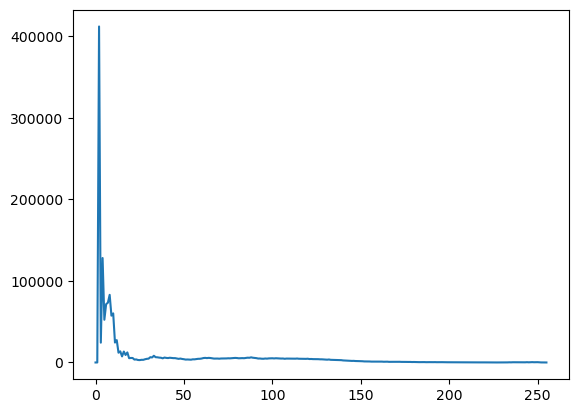

In [48]:
hist = cv.calcHist([img_comp['img_p']],[0],None,[256],[0,256])
plt.plot(hist)
plt.show()

In [52]:
img_comp['img_p'].flatten().mean()

153.59427631732015

In [53]:
mode_img = mode(img_comp['img_p'].flatten())[0][0]
print('Mode: {}'.format(mode_img))
print('Mode Adjusted (+10%): {}'.format(int(mode_img*1.10)))

Mode: 170
Mode Adjusted (+10%): 187


C:\Users\andresespinalh\AppData\Local\Temp\ipykernel_27640\46035927.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_img = mode(img_comp['img_p'].flatten())[0][0]


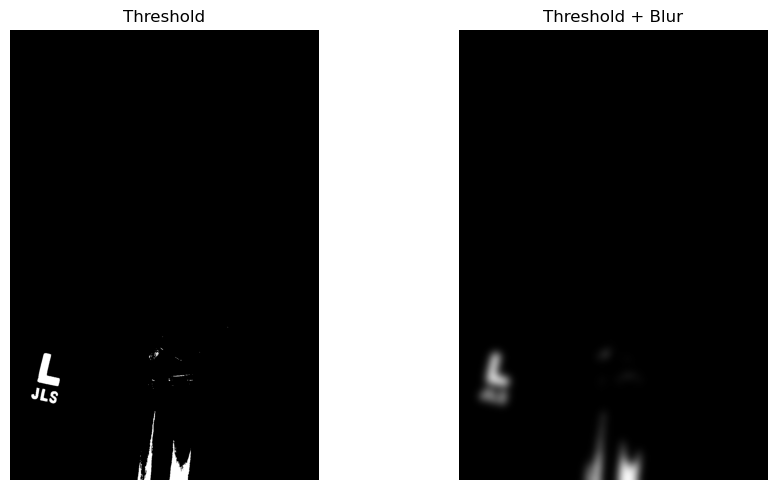

In [49]:
display_img_comp(img_thr, img_blur, 'Threshold', 'Threshold + Blur')

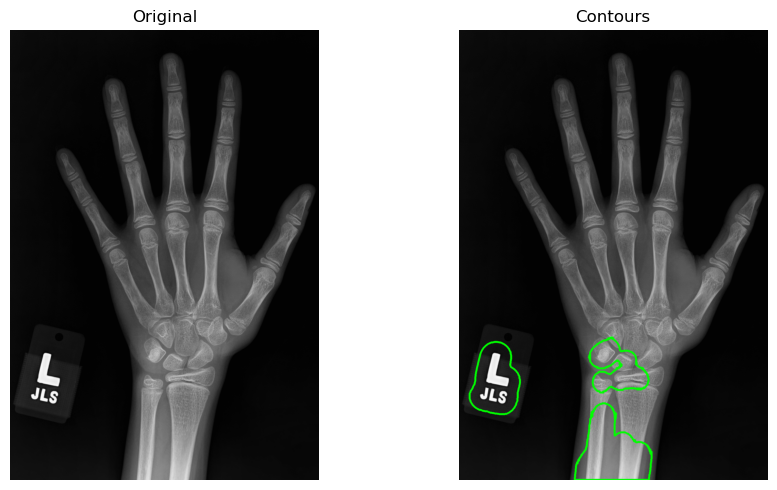

In [50]:
display_img_comp(img_comp['img_p'], img, 'Original', 'Contours')

In [ ]:
# Hola Mundo!

# Como fue el proyecto al final?
# [] Bien
# [] Mal
# [] Que buena pregunta